# Dicas de migração para o qiskit 1.0x

Fala, Eri

Então, vou te escrever como uma mensagem mesmo, tentando resumir ao máximo o que me ajudou a migrar pro qiskit 1.0x.

Em suma, eu considero que as principais funcionalidades do qiskit são:

1. Definir circuitos, aplicando operações unitárias (gates) e algumas não unitárias (medições, inicializações)
2. Simular localmente computadores quânticos ideais
3. Simular computadores quânticos com ruído
4. Enviar programas para serem rodados nos hardwares reais da IBM

Vou tentar fazer um breve comentário sobre cada um desses tópicos e incluir alguns links de referência. (Ressaltando que são comentários baseados na minha experiência pessoal com o SDK.)

## 1. Circuitos e operações

Quanto a isso, não mudou quase nada. Você pode criar circuitos, aplicar gates e desenhar da forma usual, praticamente igual às versões anteriores. Por ex.,

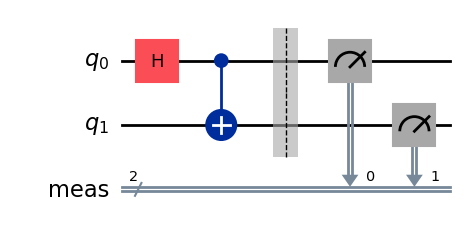

In [3]:
from qiskit import QuantumCircuit

bell_state = QuantumCircuit(2)
bell_state.h(0)
bell_state.cx(0, 1)

bell_state.measure_all()

bell_state.draw("mpl")

O foco do Qiskit 1.0x é performance em aplicações reais com os computadores quânticos de hoje em dia (a IBM já quer começar a vender o peixe de agora). Por isso eles também incluíram algumas bibliotecas com templates de circuitos relevantes para algumas aplicações. 

Por exemplo, circuitos "2-locais", que são circuitos que só envolvem interações entre qubits vizinhos, o que é muito bom pra diminuir o ruído quando os algoritmos são rodados nos computadores quânticos reais, já vem pré-construídos:

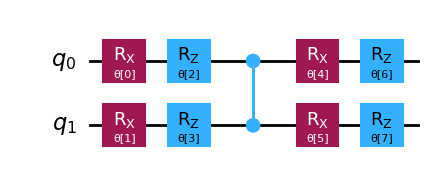

In [2]:
from qiskit.circuit.library import TwoLocal

example = TwoLocal(num_qubits = 2,
              rotation_blocks = ['rx', 'rz'],
              entanglement_blocks = 'cz',
              entanglement = 'linear',
              reps = 1, 
              insert_barriers = False)

example.decompose().draw("mpl") # O método "decompose" "quebra" o circuito em gates mais fundamentais

Vale dizer que também existem circuitos N-locais, e outros circuitos mais apropriados pra simulações em outras áreas, como é o caso do `ZZFeatureMap` pra machine learning.

O módulo 2 do curso [Variational Algorithm Design](https://learning.quantum.ibm.com/course/variational-algorithm-design) me ajudou a ter uma primeira introdução rápida (real quick mesmo!) a esses circuitos, principalmente quando eles envolvem parâmetros. A documentação da [Circuit Library](https://docs.quantum.ibm.com/api/qiskit/circuit_library) também é um material mais completo, mas bem extensivo — acho mais fácil perguntar ao chatGPT ou ir pesquisando especificamente sobre cada um à medida que se façam necessários nos nossos projetos.

# 2. Simulações

## 2.1 Anteriormente

Quanto a isso, o cenário mudou bastante. As versões anteriores vinham com uma lista de simuladores, como o `BasicAer`, `Aer`, etc., com subclasses como `"statevector_simulator` ou `qasm_simulator`, etc.

Fortuitamente, agora o negócio ficou mais simples. Basicamente (eu creio) que só restou o `AerSimulator`, que serve pra simular backends reais, e os backends Fake, sobre os quais vou falar mais já já.

## 2.2 Primitives

Isso talvez tenha sido a maior mudança, junto com os pacotes de transpilação pra cada computador quântico real (chego nisso já já). As `Primitives` são as duas operações mais básicas que um computador quântico pode fazer: `Sampler` serve pra construir a distribuição de probabilidades (coeficientes) do estado de algum circuito (similar ao `qasm` simulator nas versões anteriores); e `Estimator`, que serve pra calcular valores esperados de operadores de forma bastante eficiente.

Vale ressaltar que elas podem ser usadas _sem_ backend! (Mas caso vc queira simular [ou rodar mesmo em] um computar quântico real, é só passar um backend como argumento). Vou tentar mostrar um exemplo simples dos dois métodos.

### 2.2.1 Utilizando `Sampler`

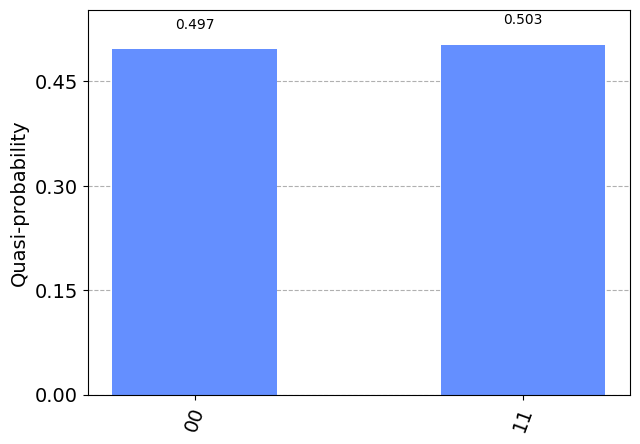

In [8]:
## Usando Sampler sem backend
from qiskit.primitives import StatevectorSampler # Quando usamos com backend isso muda (ver lá embaixo)
from qiskit.visualization import plot_distribution

sampler = StatevectorSampler()
pub = bell_state # Agora é preciso passar PUBs (Primitive Unitary Blocks) como argumento para as primitivas
job = sampler.run([bell_state], shots = 10000)

counts_no_backend = job.result()[0].data.meas.get_counts()

plot_distribution(counts_no_backend)

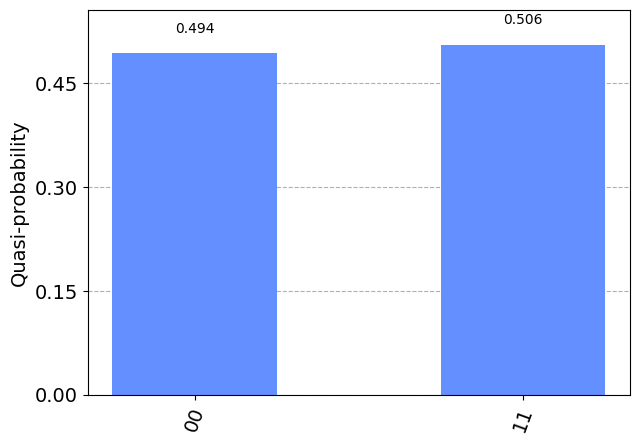

In [9]:
## Usando Sampler com AerSimulator como backend
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler

backend = AerSimulator()
sampler = Sampler(backend = AerSimulator())
job = sampler.run([bell_state], shots = 10000)
counts_backend = job.result()[0].data.meas.get_counts()

plot_distribution(counts_backend)

Veja que o resultado do código acima foi o mesmo nos dois casos. A diferença é que o último código pode ser facilmente adaptado pra rodar a simulação em um computador quântico real: basta alterar a primeira linha, por ex. `backend = "ibm_osaka"`. Em particular, isso envolveria algumas outras chatices, como gerar um `API_token` pra dizer quem você é, etc., mas you get the picture! (se quiser, dá uma olhada, por ex., nos meus [Notebooks 2-3](https://github.com/bentomontenegro/IBM-Quantum-Challenge-2024/blob/main/Lab%202/lab-2.ipynb) do challenge).

Veja que pra usar o `Sampler` sem backend chamamos a função `StatevectorSampler()`, enquanto que pra usá-lo com backend chamamos a função `SamplerV2(backend = "backend_name")`. O primeiro caso é útil pra simular localmente circuitos que não contém medições intermediárias, e o segundo é útil pra simular localmente, ou mesmo rodar nos computadores da IBM, circuitos contendo medições intermediárias (por ex. um circuito de 1 qubit em que aplicamos um gate X, medimos, e depois aplicamos um gate H, etc.).

De qualquer forma, agora também é possível _simular_ qualquer um dos computadores quânticos reais como um backend "fake". Por exemplo, o computador "Torino" pode ser simulado localmente como o backend "FakeTorino". Se quiser saber mais, dá uma olhada [aqui](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.fake_provider.FakeTorino) (na coluna lateral tem uma lista de todos os backends fake).

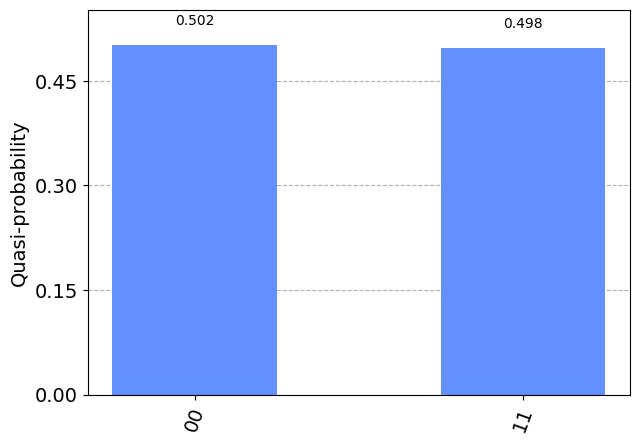

In [10]:
from qiskit_ibm_runtime.fake_provider import FakeTorino

backend = FakeTorino()
sampler = Sampler(backend = AerSimulator())
job = sampler.run([bell_state], shots = 10000)
counts_backend = job.result()[0].data.meas.get_counts()

plot_distribution(counts_backend)

Pra esse circuito tão simples os efeitos de ruído são praticamente imperceptíveis, mas pra circuitos mais complexos o negócio pode ficar realmente caótico.

### Utilizando `Estimator`

Como dito acima, `Estimator` serve pra calcular valores esperados de observáveis. A sintaxe é bem parecida com a de `Sampler`, a única diferença sendo que agora temos que passar na lista de `pubs` o circuito e o observável cujo valor esperado desejamos obter. No caso de circuitos parametrizados também passamos a lista de parâmetros a serem assignados ao circuito, como no exemplo abaixo para o Hamiltoniano adimensional
\begin{equation}
    H = -\frac{1}{2} I \otimes X -\frac{1}{2} X \otimes X
\end{equation}

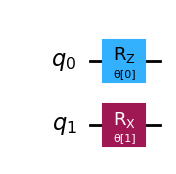

In [11]:
## Criando um circuito parametrizado
from qiskit.circuit import QuantumCircuit, ParameterVector

theta = ParameterVector("θ", 2)

param_qc = QuantumCircuit(2)
param_qc.rz(theta[0], 0)
param_qc.rx(theta[1], 1)

param_qc.draw("mpl")

In [12]:
## Estimator para um circuito parametrizado
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator

## Definindo o Hamiltoniano
Hamiltonian = SparsePauliOp(data = ["XI", "XX"], coeffs = [-1/2, -1/2])

## Valores a serem assignados aos parâmetros
theta_values = [np.pi/2, np.pi/3]

## Utilizando Estimator com AerSimulator como backend
backend = AerSimulator()
pubs = (param_qc, Hamiltonian, theta_values) # Pra um circuito "qc" sem parametros, pubs = (qc, Hamiltonian) apenas
estimator = Estimator(backend = AerSimulator())
job = estimator.run(pubs = [pubs])

expectation_value = job.result()[0].data.evs
expectation_value

array(0.0090332)

## 3 e 4. Simulações com ruído

Aí em cima já falei um pouco sobre isso, mas vale ressaltar que agora é possível _transpilar_ circuitos para simulações de backend fake e backend reais de forma que os gates que aplicamos são decompostos em gates mais apropriados para o computador quântico que queremos trabalhar.

Os efeitos de ruído pra operações entre dois qubits que estão muito distantes na arquitetura de um processador quântico são muito acentuados. Se temos então, por ex., um circuito de 50 qubits e aplicamos um portão CX nos qubits 1 e 43, o que o computador quântico faz é "decompor" esse portão CX em uma sequência de operações "SWAP" (uma operação que "troca" a posição de dois qubits) e rotações RX, RY ou RZ, dependendo das quais são mais apropriadas pro chip em questão. O problema é que essa operação é relativamente custosa de ser implementada, o que fez com que os engenheiros da IBM desenvolvessem novas técnicas de transpilação como utilizar `PassManager`s com a função `generate_preset_pass_manager`. Isso é um tópico relativamente avançado, e acho que o melhor materia que vi até agora sobre é o [Notebook 3](https://github.com/bentomontenegro/IBM-Quantum-Challenge-2024/tree/main/Lab%203) do Quantum Challenge.